<a href="https://colab.research.google.com/github/Simarjit1303/Data-Science/blob/main/exercises/machine-learning/supervised-learning/titanic_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Competition
You should build an end-to-end machine learning pipeline to predict survivors of the Titanic disaster and participate in the corresponding Kaggle competition. In particular, you should do the following:
- Read the Titanic competition page on [Kaggle](https://www.kaggle.com/competitions/titanic/overview).
- Load the `titanic` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the datasets folder.
- Split the dataset into training and test sets using [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- Build an end-to-end machine learning pipeline, including all necessary steps, to have a running solution with some performance.
- Collaborate with your groupmates to finalize your pipeline by
    - reading the discussion forum to learn from other community members;
    - discussing the bottlenecks of your current solution;
    - running experiments on your pipeline;
    - improving the performance of your pipeline.
- Test the best pipeline on the test set and report various [evaluation metrics](https://scikit-learn.org/0.15/modules/model_evaluation.html).  
- Present your pipeline.
- Submit your predictions to Kaggle.

In [53]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Data Exploartion and Preprocessing

In [54]:
dataset = pd.read_csv('https://raw.githubusercontent.com/m-mahdavi/teaching/refs/heads/main/datasets/titanic.csv')
dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [55]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [56]:
# checking missing values
dataset.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


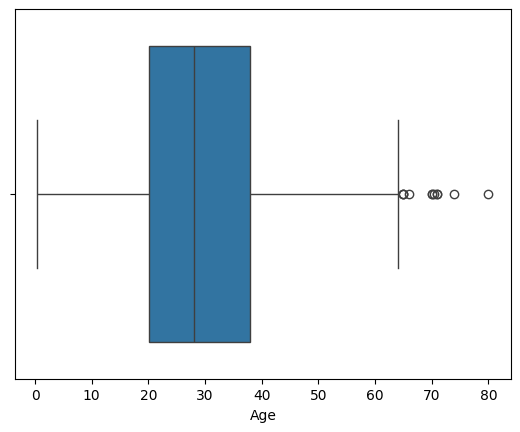

In [57]:
# finding outliers
sns.boxplot(x=dataset['Age'])
plt.show()

In [58]:
# Addind missing values in 'Age' with the median
dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

# Adding missing values in 'Embarked' with the mode
dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)

# Impute missing values in 'Cabin' with 'Unknown'
dataset['Cabin'].fillna('Unknown', inplace=True)

# Verifing if there are any remaining missing values
dataset.isnull().sum()


<ipython-input-58-90ca47960249>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
<ipython-input-58-90ca47960249>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


# Feature Engineering

In [59]:
# 1. Title Extraction
dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 2. Creating a new column to put family under one category
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# 3. IsAlone
dataset['IsAlone'] = 0
dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# 4. Grouping passengers into age categories
dataset['AgeBin'] = pd.cut(dataset['Age'], bins=[0, 12, 20, 60, 100], labels=['Child', 'Young Adult', 'Adult', 'Senior'])

# 5. Embarked Encoding (One-Hot Encoding)
embarked_dummies = pd.get_dummies(dataset['Embarked'], prefix='Embarked')
dataset = pd.concat([dataset, embarked_dummies], axis=1)

# Dropping unnecessary original columns
dataset.drop(['PassengerId','Name', 'SibSp', 'Parch', 'Embarked'], axis=1, inplace=True)

dataset.head(10)


,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Title,FamilySize,IsAlone,AgeBin,Embarked_C,Embarked_Q,Embarked_S
0,0,3,male,22.0,A/5 21171,7.2500,Unknown,Mr,2,0,Adult,False,False,True
1,1,1,female,38.0,PC 17599,71.2833,C85,Mrs,2,0,Adult,True,False,False
2,1,3,female,26.0,STON/O2. 3101282,7.9250,Unknown,Miss,1,1,Adult,False,False,True
3,1,1,female,35.0,113803,53.1000,C123,Mrs,2,0,Adult,False,False,True
4,0,3,male,35.0,373450,8.0500,Unknown,Mr,1,1,Adult,False,False,True
5,0,3,male,28.0,330877,8.4583,Unknown,Mr,1,1,Adult,False,True,False
6,0,1,male,54.0,17463,51.8625,E46,Mr,1,1,Adult,False,False,True
7,0,3,male,2.0,349909,21.0750,Unknown,Master,5,0,Child,False,False,True
8,1,3,female,27.0,347742,11.1333,Unknown,Mrs,3,0,Adult,False,False,True
9,1,2,female,14.0,237736,30.0708,Unknown,Mrs,2,0,Young Adult,True,False,False


# Feature Scaling

In [60]:
# 1. Defining features and target
features = ['Pclass', 'FamilySize', 'IsAlone', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
target = 'Survived'

# 2. Converting categorical features to numerical using one-hot encoding (if not already done)
dataset = pd.get_dummies(dataset, columns=['Sex', 'Title', 'AgeBin'], drop_first=True)

# 3. Spliiting data into test and train data
X = dataset[features]
y = dataset[target]
X_train_data, X_test_data, y_train, y_test = train_test_split(X, y, random_state=42)

# 4. Feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_data)
X_test_scaled = scaler.transform(X_test_data)


# Data Modelling

In [62]:
# Define models and hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
}

#  Perform Randomized Search CV for each model
best_model = None
best_accuracy = 0

for model_name, model_data in models.items():
    random_search = RandomizedSearchCV(
        estimator=model_data['model'],
        param_distributions=model_data['param_grid'],
        n_iter=10,
        scoring='accuracy',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train)

    accuracy = random_search.best_score_

    print(f"{model_name} Best Accuracy (CV): {accuracy}")
    print(f"{model_name} Best Hyperparameters: {random_search.best_params_}\n")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = random_search.best_estimator_
print(f"The best model is: {best_model}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Logistic Regression Best Accuracy (CV): 0.66911682190551
Logistic Regression Best Hyperparameters: {'C': 1}

Random Forest Best Accuracy (CV): 0.6916283245427
Random Forest Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Support Vector Machine Best Accuracy (CV): 0.6960947143979351
Support Vector Machine Best Hyperparameters: {'kernel': 'rbf', 'C': 1}

The best model is: SVC(C=1, random_state=42)
